# ttnn demo: Bert Attention

In [1]:
import torch
import transformers
import ttnn
import time

In [2]:
model_name = "phiyodr/bert-large-finetuned-squad2"
batch_size = 8
sequence_size = 384

In [3]:
config = transformers.BertConfig.from_pretrained(model_name)
model = transformers.models.bert.modeling_bert.BertSelfAttention(config).eval()

2024-02-23 17:47:18.132 | INFO     | ttnn.tracer:visualize:178 - Dumping graph of the model to None


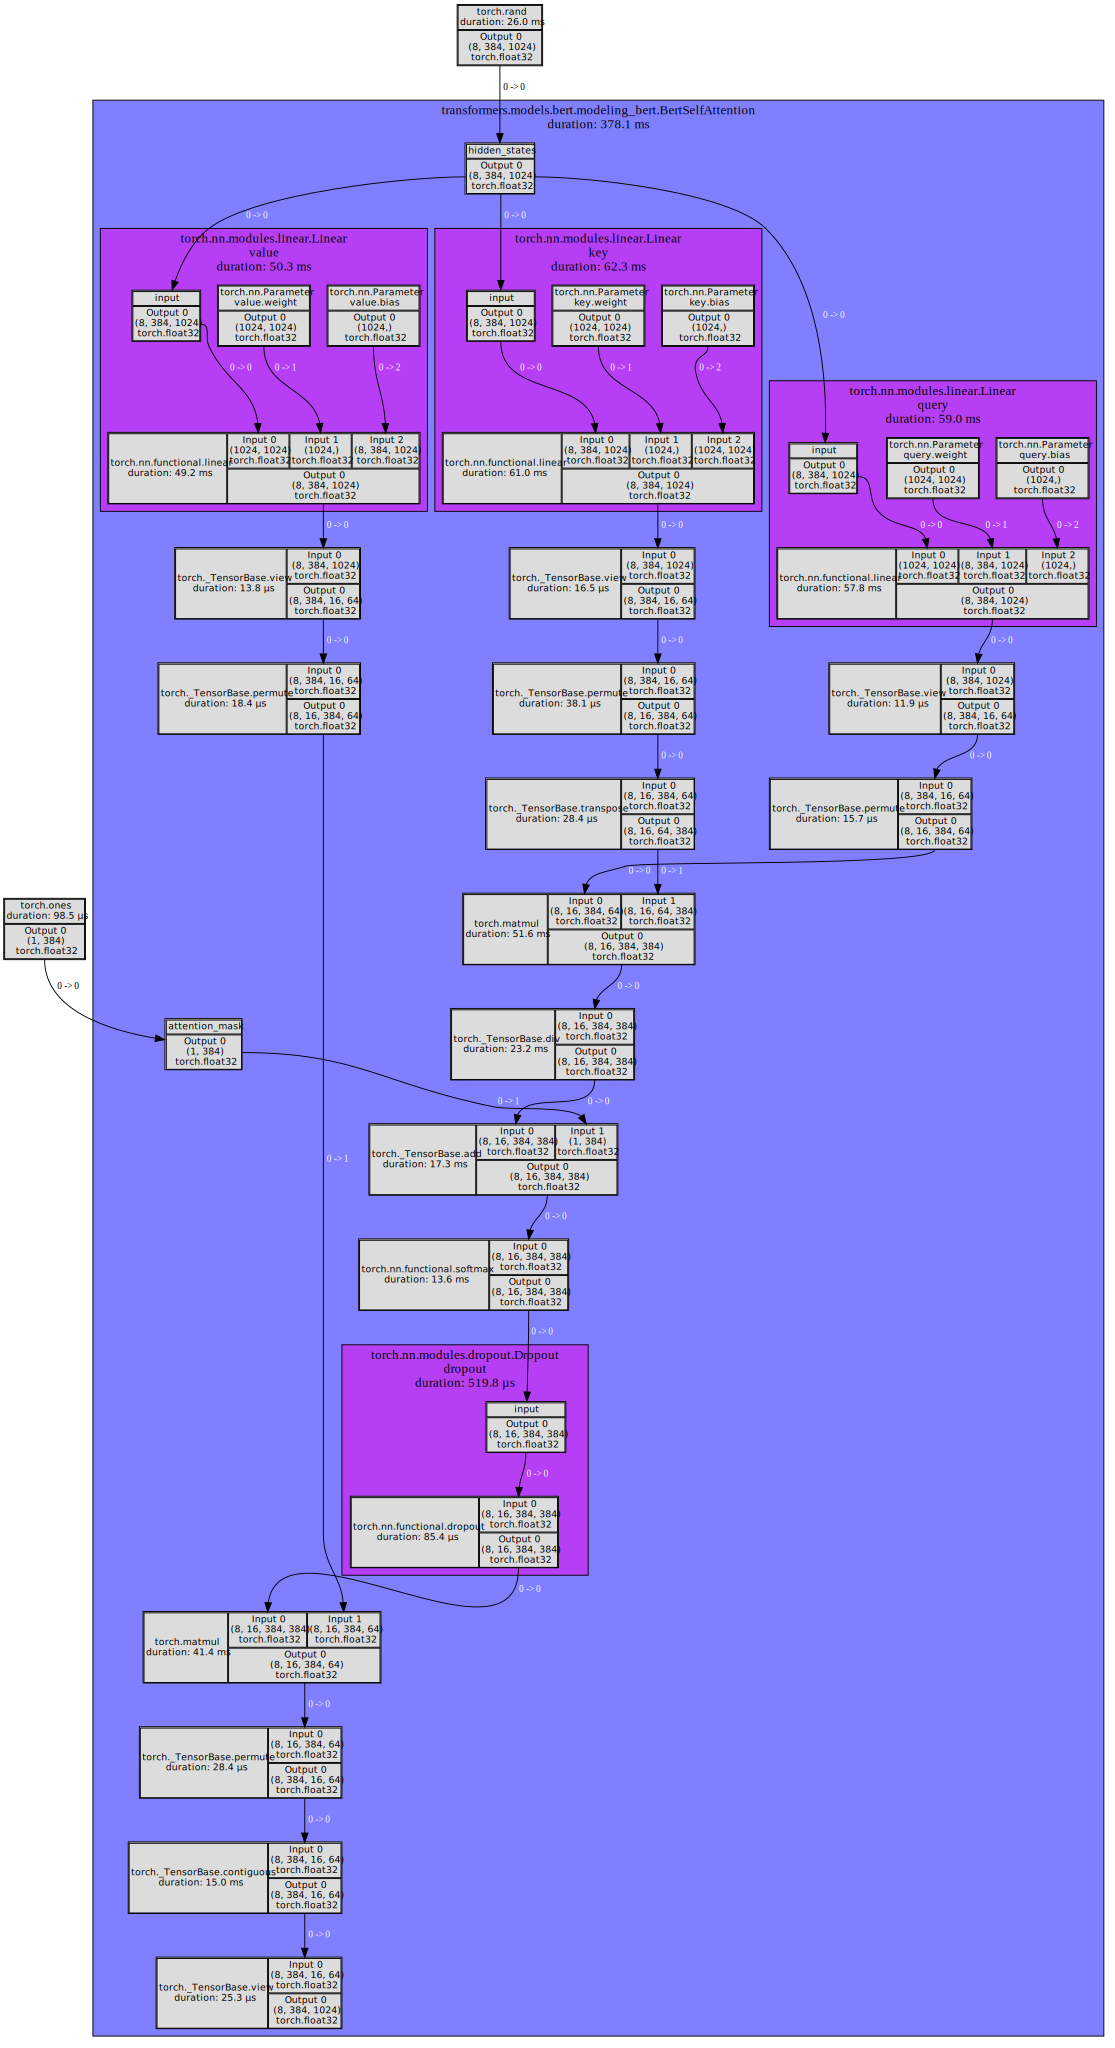

In [4]:
with ttnn.tracer.trace():
    torch_hidden_states = torch.rand((batch_size, sequence_size, config.hidden_size))
    torch_attention_mask = torch.ones(1, sequence_size)
    torch_output, *_ = model(torch_hidden_states, attention_mask=torch_attention_mask)
ttnn.tracer.visualize(torch_output)

In [5]:
from ttnn.model_preprocessing import preprocess_model_parameters

device_id = 0
device = ttnn.open_device(device_id=device_id)

                  Metal | INFO     | Initializing device 0
                 Device | INFO     | Opening user mode device driver
2024-02-23 17:47:18.277 | INFO     | SiliconDriver   - Detected 1 PCI device : {0}
2024-02-23 17:47:18.294 | WARNING  | SiliconDriver   - init_detect_tt_device_numanodes(): Could not determine NumaNodeSet for TT device (physical_device_id: 0 pci_bus_id: 0000:00:08.0)
2024-02-23 17:47:18.294 | WARNING  | SiliconDriver   - Could not find NumaNodeSet for TT Device (physical_device_id: 0 pci_bus_id: 0000:00:08.0)
2024-02-23 17:47:18.296 | WARNING  | SiliconDriver   - bind_area_memory_nodeset(): Unable to determine TT Device to NumaNode mapping for physical_device_id: 0. Skipping membind.
---- ttSiliconDevice::init_hugepage: bind_area_to_memory_nodeset() failed (physical_device_id: 0 ch: 0). Hugepage allocation is not on NumaNode matching TT Device. Side-Effect is decreased Device->Host perf (Issue #893).
                  Metal | INFO     | AI CLK for device 0 is:

In [6]:
def ttnn_self_attention(
    config,
    hidden_states,
    *,
    parameters,
):
    batch_size, sequence_size, hidden_size = hidden_states.shape
    head_size = hidden_size // config.num_attention_heads

    query = hidden_states @ parameters.query.weight
    query = query + parameters.query.bias
    query = ttnn.to_layout(query, layout=ttnn.ROW_MAJOR_LAYOUT)
    query = ttnn.reshape(query, (batch_size, sequence_size, config.num_attention_heads, head_size))
    query = ttnn.to_layout(query, layout=ttnn.TILE_LAYOUT)
    query = ttnn.permute(query, (0, 2, 1, 3))

    key = hidden_states @ parameters.key.weight
    key = key + parameters.key.bias
    key = ttnn.to_layout(key, layout=ttnn.ROW_MAJOR_LAYOUT)
    key = ttnn.reshape(key, (batch_size, sequence_size, config.num_attention_heads, head_size))
    key = ttnn.to_layout(key, layout=ttnn.TILE_LAYOUT)
    key = ttnn.permute(key, (0, 2, 3, 1))

    value = hidden_states @ parameters.value.weight
    value = value + parameters.value.bias
    value = ttnn.to_layout(value, layout=ttnn.ROW_MAJOR_LAYOUT)
    value = ttnn.reshape(value, (batch_size, sequence_size, config.num_attention_heads, head_size))
    value = ttnn.to_layout(value, layout=ttnn.TILE_LAYOUT)
    value = ttnn.permute(value, (0, 2, 1, 3))

    attention_scores = query @ key
    attention_scores = attention_scores * (1 / (head_size**0.5))
    attention_probs = ttnn.softmax(attention_scores, dim=-1)

    context_layer = attention_probs @ value
    context_layer = ttnn.permute(context_layer, (0, 2, 1, 3))
    context_layer = ttnn.to_layout(context_layer, layout=ttnn.ROW_MAJOR_LAYOUT)
    context_layer = ttnn.reshape(context_layer, (batch_size, sequence_size, hidden_size))
    context_layer = ttnn.to_layout(context_layer, layout=ttnn.TILE_LAYOUT)

    return context_layer

2024-02-23 17:47:19.416 | WARNING  | ttnn.model_preprocessing:preprocess_model:537 - ttnn: model cache can be enabled using TTNN_ENABLE_MODEL_CACHE=True
2024-02-23 17:47:19.522 | INFO     | ttnn.model_preprocessing:preprocess_model:604 - Moving model weights to device
2024-02-23 17:47:19.524 | INFO     | ttnn.model_preprocessing:preprocess_model:606 - Moved model weights to device
2024-02-23 17:47:26.675 | INFO     | ttnn.tracer:visualize:178 - Dumping graph of the model to None


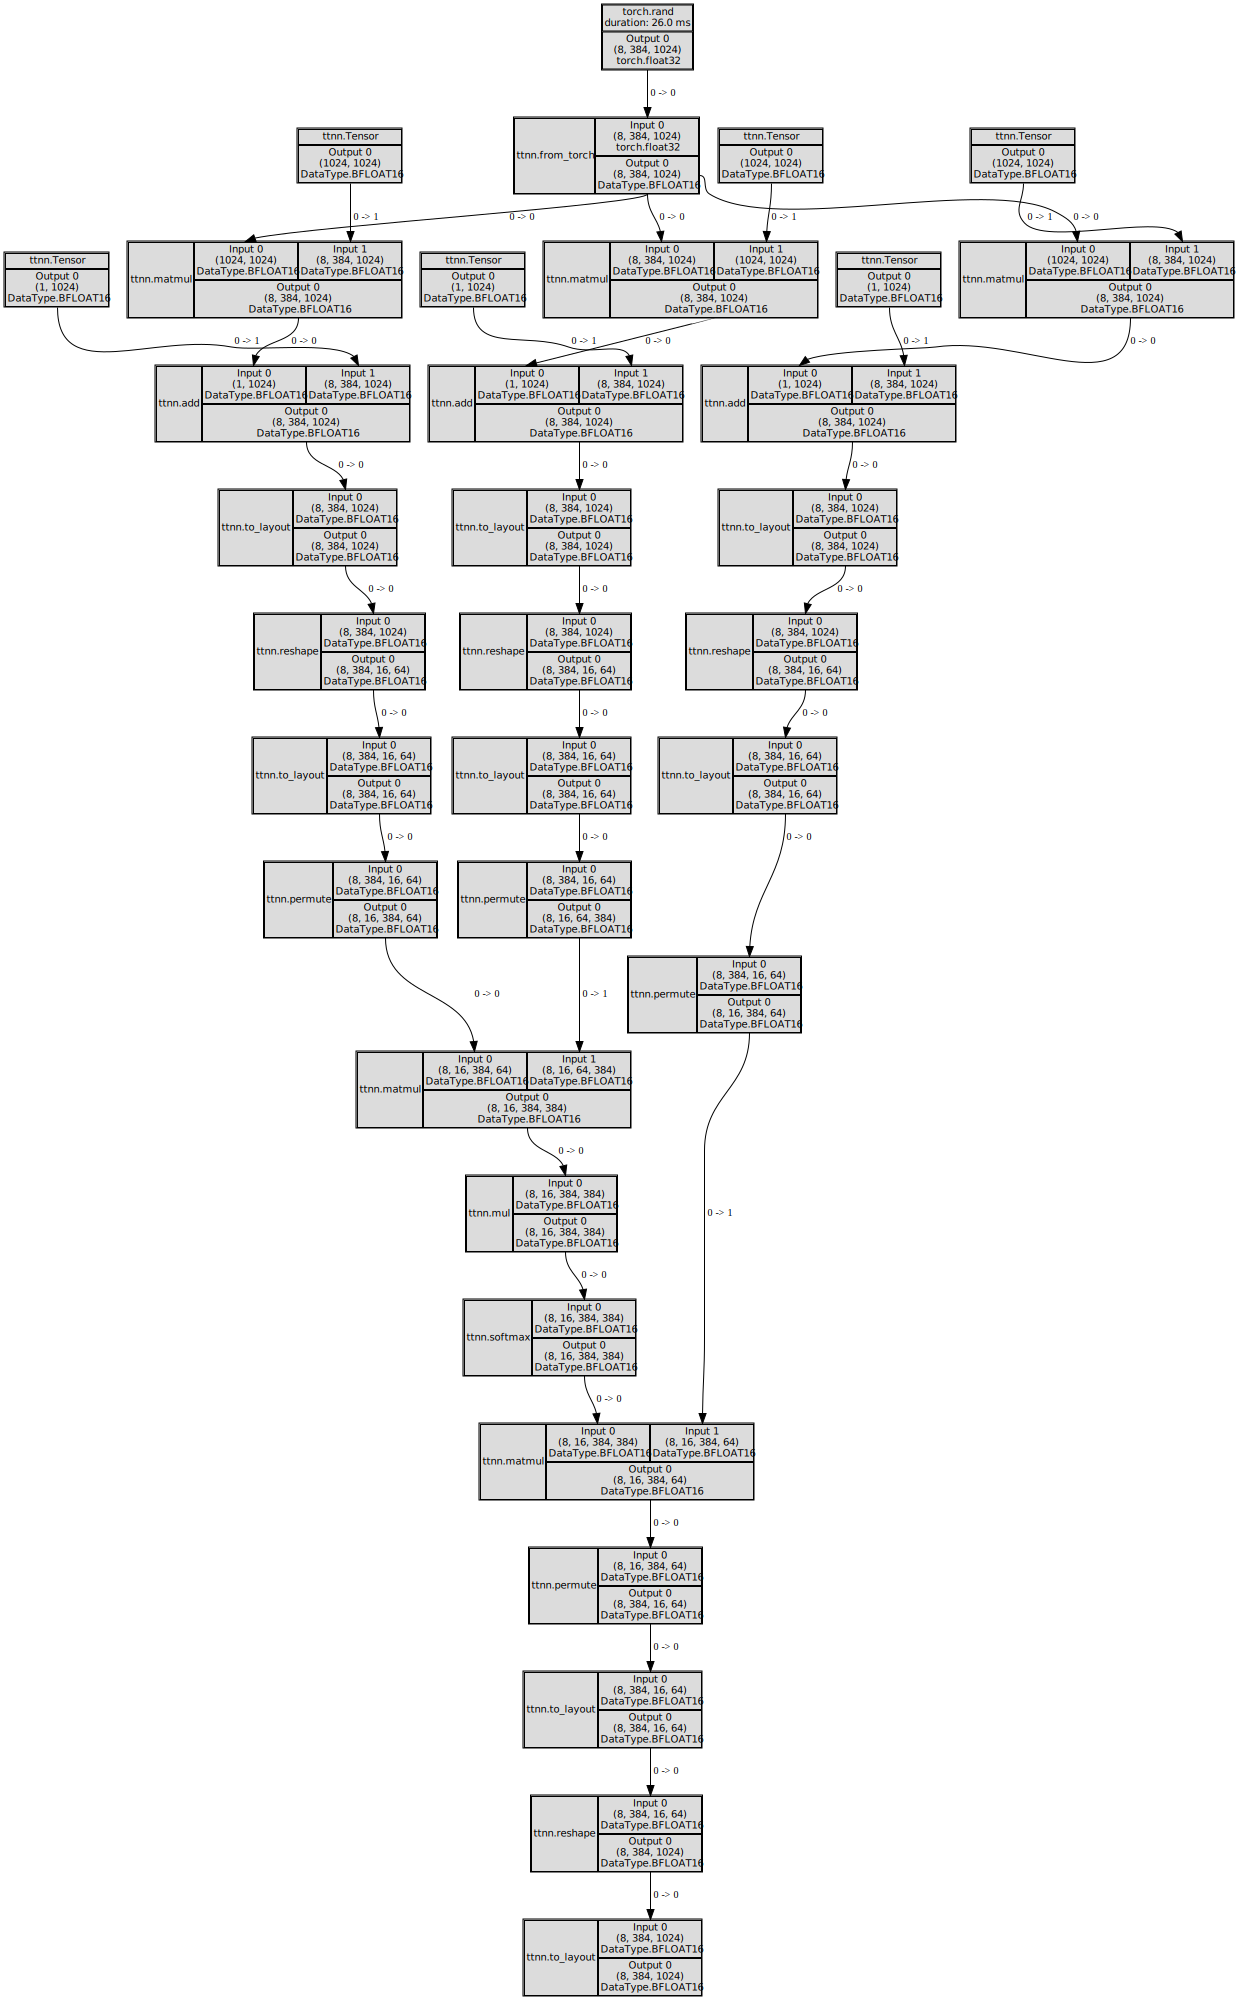

In [7]:
parameters = ttnn.model_preprocessing.preprocess_model_parameters(
    initialize_model=lambda: model,
    device=device,
)

with ttnn.tracer.trace():
    hidden_states = ttnn.from_torch(torch_hidden_states, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT, device=device)
    output = ttnn_self_attention(
        config,
        hidden_states,
        parameters=parameters,
    )
ttnn.tracer.visualize(output)

## Run a subsequent iteration of Multi-Head Attention

In [8]:
def optimized_ttnn_self_attention(
    config,
    hidden_states,
    *,
    parameters,
):
    batch_size, _, hidden_size = hidden_states.shape
    head_size = hidden_size // config.num_attention_heads
    
    hidden_states = ttnn.to_layout(hidden_states, ttnn.TILE_LAYOUT)

    query_key_value = ttnn.linear(
        hidden_states,
        parameters.query_key_value.weight,
        bias=parameters.query_key_value.bias,
        memory_config=ttnn.L1_MEMORY_CONFIG,
        dtype=ttnn.bfloat8_b,
        core_grid=ttnn.CoreGrid(batch_size, x=hidden_states.device.core_grid.x),
    )

    (
        query,
        key,
        value,
    ) = ttnn.transformer.split_query_key_value_and_split_heads(
        query_key_value,
        memory_config=ttnn.L1_MEMORY_CONFIG,
        num_heads=config.num_attention_heads,
    )
    ttnn.deallocate(query_key_value)

    attention_scores = ttnn.matmul(
        query,
        key,
        memory_config=ttnn.L1_MEMORY_CONFIG,
        dtype=ttnn.bfloat16,
        core_grid=ttnn.CoreGrid(batch_size, x=hidden_states.device.core_grid.x),
    )
    ttnn.deallocate(query)
    ttnn.deallocate(key)

    attention_probs = ttnn.transformer.attention_softmax(attention_scores, attention_mask=None, head_size=head_size)

    context_layer = ttnn.matmul(
        attention_probs,
        value,
        memory_config=ttnn.L1_MEMORY_CONFIG,
        dtype=ttnn.bfloat8_b,
        core_grid=ttnn.CoreGrid(batch_size, x=hidden_states.device.core_grid.x),
    )
    ttnn.deallocate(attention_probs)

    context_layer = ttnn.transformer.concatenate_heads(
        context_layer,
        memory_config=ttnn.L1_MEMORY_CONFIG,
    )

    return context_layer

In [9]:
def custom_preprocessor(torch_model, name):
    import torch
    from ttnn.model_preprocessing import (
        preprocess_linear_bias,
        preprocess_linear_weight,
    )

    parameters = {}
    if hasattr(torch_model, "query") and hasattr(torch_model, "key") and hasattr(torch_model, "value"):
        qkv_weight = torch.cat(
            [
                torch_model.query.weight,
                torch_model.key.weight,
                torch_model.value.weight,
            ],
            dim=0,
        )
        qkv_bias = torch.cat(
            [torch_model.query.bias, torch_model.key.bias, torch_model.value.bias],
            dim=0,
        )

        parameters = {"query_key_value": {}}
        parameters["query_key_value"]["weight"] = preprocess_linear_weight(qkv_weight, dtype=ttnn.bfloat8_b)
        parameters["query_key_value"]["bias"] = preprocess_linear_bias(qkv_bias, dtype=ttnn.bfloat8_b)
    return parameters

2024-02-23 17:47:26.780 | WARNING  | ttnn.model_preprocessing:preprocess_model:537 - ttnn: model cache can be enabled using TTNN_ENABLE_MODEL_CACHE=True
2024-02-23 17:47:27.087 | INFO     | ttnn.model_preprocessing:preprocess_model:604 - Moving model weights to device
2024-02-23 17:47:27.092 | INFO     | ttnn.model_preprocessing:preprocess_model:606 - Moved model weights to device
2024-02-23 17:47:30.395 | INFO     | ttnn.tracer:visualize:178 - Dumping graph of the model to None


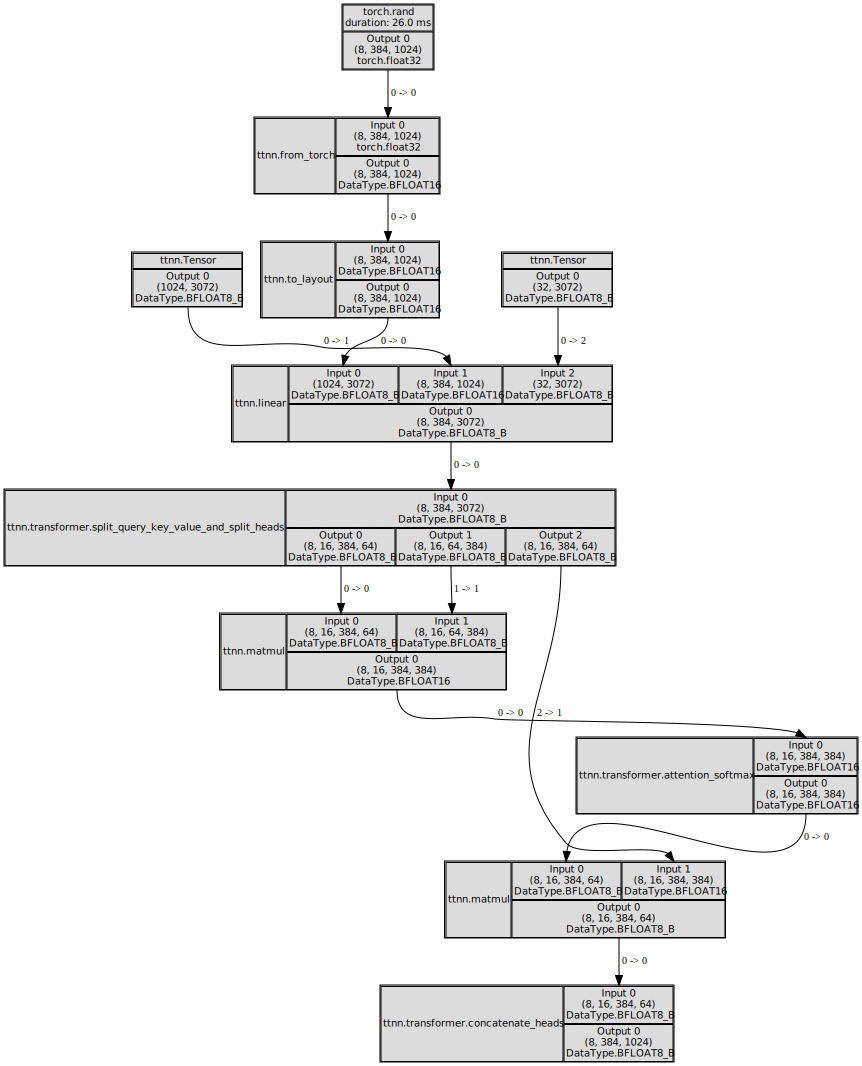

In [10]:
optimized_parameters = ttnn.model_preprocessing.preprocess_model_parameters(
    initialize_model=lambda: model,
    device=device,
    custom_preprocessor=custom_preprocessor,
)

with ttnn.tracer.trace():
    hidden_states = ttnn.from_torch(torch_hidden_states, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT, device=device)
    output = optimized_ttnn_self_attention(
        config,
        hidden_states,
        parameters=optimized_parameters,
    )
ttnn.tracer.visualize(output)

In [11]:
ttnn.enable_program_cache()

                     Op | INFO     | Program Cache: enabled.


In [12]:
durations = []
with ttnn.disable_validate_decorator():
    for _ in range(2):
        start = time.time()
        output = optimized_ttnn_self_attention(
            config,
            hidden_states,
            parameters=optimized_parameters,
        )
        end = time.time()
        output = ttnn.to_torch(output)
        end = time.time()
        print(end - start)
        durations.append(end - start)

0.1026604175567627
0.09372687339782715


In [13]:
optimized_durations = []
with ttnn.disable_validate_decorator():
    for _ in range(2):
        start = time.time()
        output = ttnn_self_attention(
            config,
            hidden_states,
            parameters=parameters,
        )
        output = ttnn.to_torch(output)
        end = time.time()
        print(end - start)
        optimized_durations.append(end - start)

1.3268611431121826
1.3101401329040527


In [15]:
ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
